In [1]:
%load_ext watermark
%watermark -a 'cs224' -u -d -v -p numpy,xarray,scipy,pandas,sklearn,matplotlib,seaborn,pymc3,lifelines,rpy2

cs224 
last updated: 2020-04-08 

CPython 3.6.10
IPython 7.13.0

numpy 1.18.1
xarray 0.15.0
scipy 1.4.1
pandas 1.0.2
sklearn 0.22.1
matplotlib 3.1.3
seaborn 0.10.0
pymc3 3.8
lifelines 0.24.2
rpy2 3.2.6


In [2]:
%matplotlib inline
import numpy as np, scipy, scipy.stats as stats, scipy.special, scipy.misc, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, xarray as xr
import matplotlib as mpl

import pymc3 as pm

import theano as thno
import theano.tensor as T

import datetime, time, math
from dateutil import relativedelta

from collections import OrderedDict

SEED = 41
np.random.seed(SEED)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(linewidth=1000)
np.set_printoptions(suppress=True)
np.core.arrayprint._line_width = 180

sns.set()

In [3]:
from IPython.display import display, HTML

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        if type(df) == np.ndarray:
            df = pd.DataFrame(df)
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline"')
    # print(html_str)
    display_html(html_str,raw=True)

CSS = """
.output {
    flex-direction: row;
}
"""

def display_graphs_side_by_side(*args):
    html_str='<table><tr>'
    for g in args:
        html_str += '<td>'
        html_str += g._repr_svg_()
        html_str += '</td>'
    html_str += '</tr></table>'
    display_html(html_str,raw=True)
    

display(HTML("<style>.container { width:70% !important; }</style>"))

In [4]:
%load_ext autoreload
%autoreload 1
%aimport covid19

* [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution)

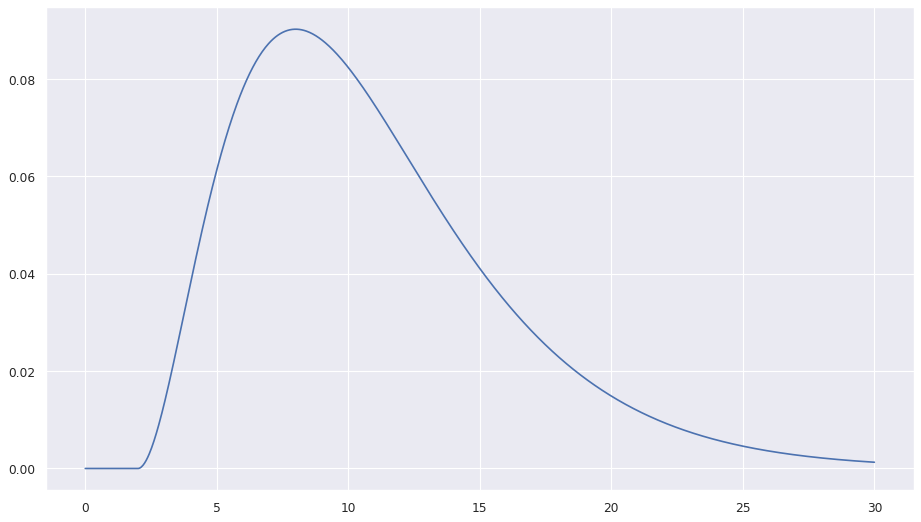

In [5]:
x = np.linspace(0.0,30.0,1000)
gamma_loc   = 2.0
gamma_k     = 3.0
gamme_theta = 3.0
y = stats.gamma(gamma_k, loc=gamma_loc, scale=gamme_theta).pdf(x)
fig=plt.figure(figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(111)
ax.plot(x,y)

In [6]:
china_mortality_analysis = covid19.MortalityAnalysis('China')

In [7]:
china_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-03,82511,76760,3326,79,195,4
2020-04-04,82543,76946,3330,32,186,4
2020-04-05,82602,77207,3333,59,261,3
2020-04-06,82665,77310,3335,63,103,2
2020-04-07,82718,77410,3335,53,100,0


In [8]:
# china_mortality_analysis.df_lifelines_individual.observed_death.sum()

In [9]:
# china_mortality_analysis.df.head()

In [10]:
# china_mortality_analysis.df.tail()

In [8]:
china_mortality_analysis.fit()

In [12]:
# china_mortality_analysis.wbf.print_summary()

# expected_life_time = china_mortality_analysis.wbf.lambda_ * scipy.special.gamma(1 + 1 / china_mortality_analysis.wbf.rho_)
# expected_life_time/365

In [9]:
china_mortality_analysis.death_rate()

(4.06, 3.93, 4.2)

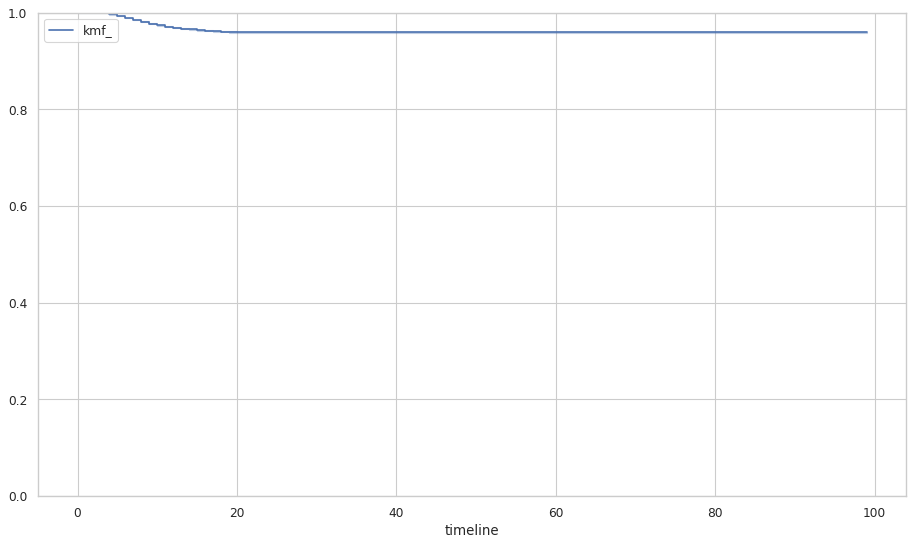

In [10]:
china_mortality_analysis.plot()

(3.16, 3.01, 3.32)


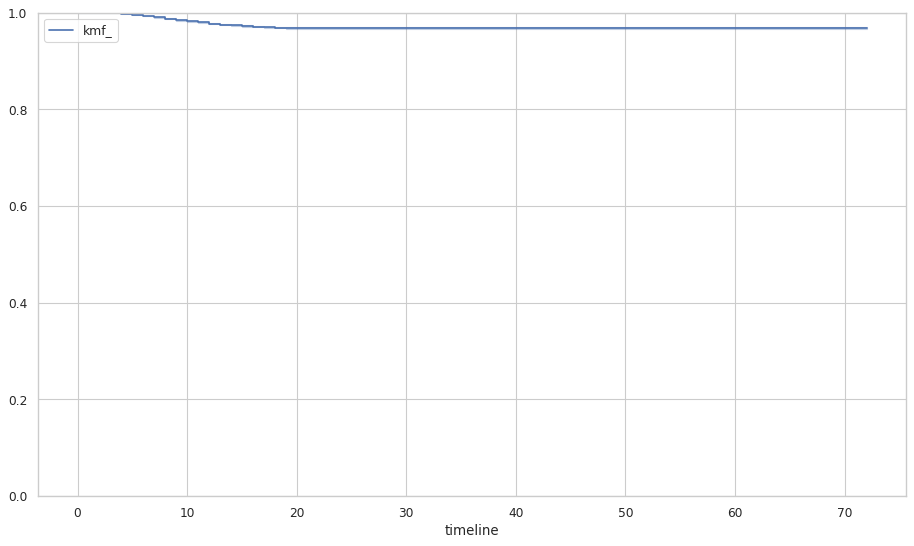

In [11]:
germany_mortality_analysis = covid19.MortalityAnalysis('Germany')
germany_mortality_analysis.fit()
print(germany_mortality_analysis.death_rate())
germany_mortality_analysis.plot()

In [12]:
germany_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-03,85436,24981,1153,5986,2541,151
2020-04-04,91314,26144,1319,5878,1163,166
2020-04-05,95950,26469,1452,4636,325,133
2020-04-06,98945,36081,1578,2995,9612,126
2020-04-07,103036,38287,1814,4091,2206,236


In [13]:
germany_mortality_analysis.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,3256.0,1814,1442.0,103.0,14,3605.0


In [13]:
germany_mortality_analysis.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,2949.0,1578,1371.0,98.0,14,3426.0


(2.58, 2.26, 2.95)


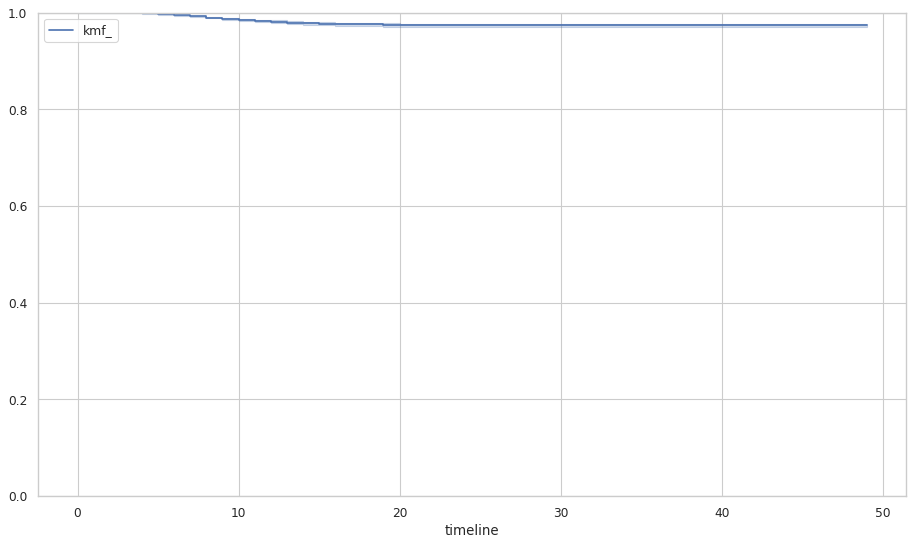

In [14]:
austria_mortality_analysis = covid19.MortalityAnalysis('Austria', first_date=pd.to_datetime('2020-03-12'), init_add=600)
austria_mortality_analysis.fit()
print(austria_mortality_analysis.death_rate())
austria_mortality_analysis.plot()

In [15]:
austria_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-03,11739,2022,168,401,273,10
2020-04-04,12013,2998,204,274,976,36
2020-04-05,12179,2998,204,166,0,0
2020-04-06,12415,3463,220,236,465,16
2020-04-07,12653,4046,243,238,583,23


In [16]:
austria_mortality_analysis.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,342.0,243,99.0,7.0,14,247.0


In [16]:
austria_mortality_analysis.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,323.0,220,103.0,7.0,14,258.0


(2.02, 1.75, 2.32)


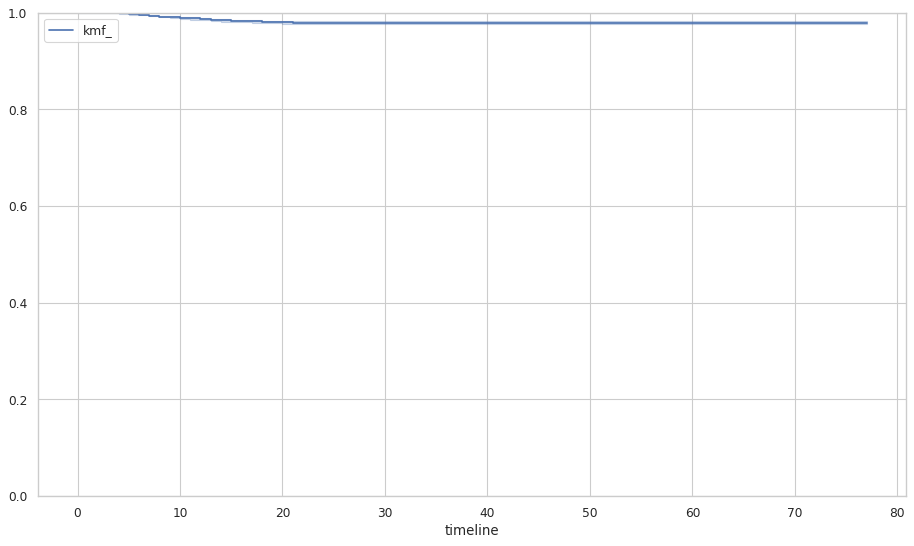

In [17]:
south_korea_name = 'Korea, South'
south_korea_mortality_analysis = covid19.MortalityAnalysis(south_korea_name)
south_korea_mortality_analysis.fit()
# south_korea_mortality_analysis2 = covid19.MortalityAnalysis(south_korea_name, first_date=pd.to_datetime('2020-02-20'), init_add=900)
# south_korea_mortality_analysis2.fit()
print(south_korea_mortality_analysis.death_rate())
# print(south_korea_mortality_analysis2.death_rate())
# print(south_korea_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
south_korea_mortality_analysis.plot()

In [18]:
south_korea_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-03,10062,6021,174,86,193,5
2020-04-04,10156,6325,177,94,304,3
2020-04-05,10237,6463,183,81,138,6
2020-04-06,10284,6598,186,47,135,3
2020-04-07,10331,6694,192,47,96,6


In [20]:
# south_korea_mortality_analysis.prepend_df

(27.93, 27.16, 28.71)
(3.46, 3.36, 3.56)
453992


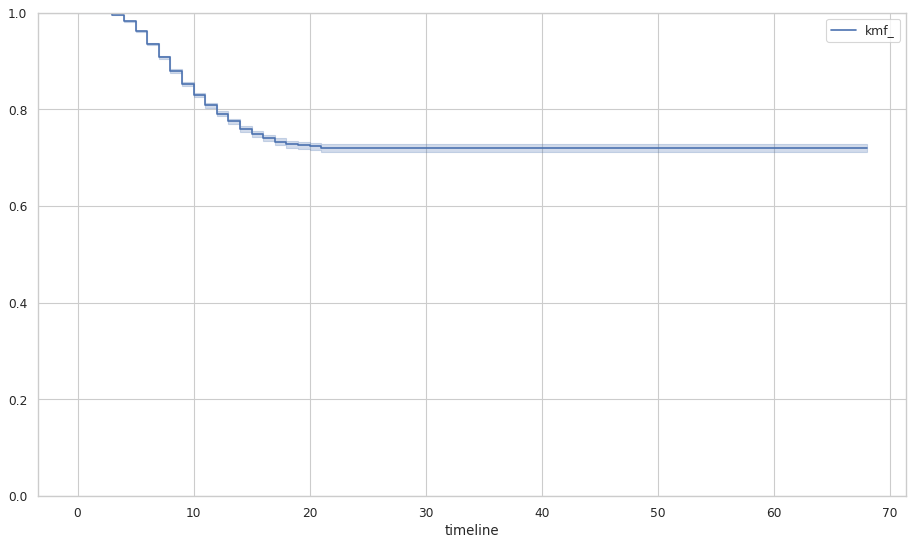

In [19]:
uk_name = 'United Kingdom'
uk_mortality_analysis = covid19.MortalityAnalysis(uk_name)
uk_mortality_analysis.fit()
uk_mortality_analysis2 = covid19.MortalityAnalysis(uk_name, first_date=pd.to_datetime('2020-03-05'), init_add=800, mult=8.0)
uk_mortality_analysis2.fit()
print(uk_mortality_analysis.death_rate())
print(uk_mortality_analysis2.death_rate())
print(uk_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
uk_mortality_analysis.plot()

In [20]:
uk_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-02,34173,192,2926,4308,13,569
2020-04-03,38689,208,3611,4516,16,685
2020-04-04,42477,215,4320,3788,7,709
2020-04-05,48436,229,4943,5959,14,623
2020-04-06,52279,287,5385,3843,58,442


In [20]:
uk_mortality_analysis2.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,15708.0,6171,9537.0,681.0,14,23843.0


In [21]:
uk_mortality_analysis2.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,14735.0,5385,9350.0,668.0,14,23374.0


In [30]:
# pd.options.mode.chained_assignment = "raise"

(8.08, 7.9, 8.27)
(2.72, 2.65, 2.78)
1190019


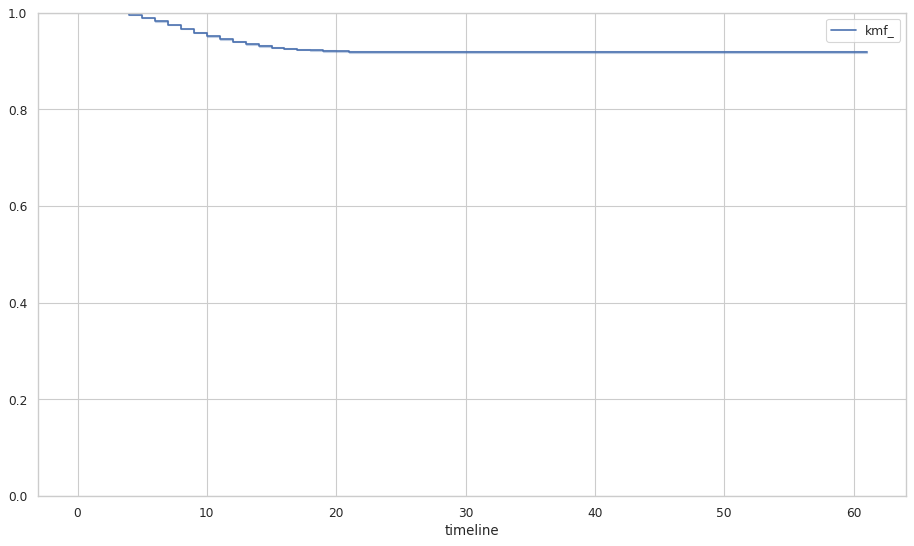

In [21]:
us_mortality_analysis = covid19.MortalityAnalysis('US', first_date=pd.to_datetime('2020-02-29'), init_add=950)
us_mortality_analysis.fit()
us_mortality_analysis2 = covid19.MortalityAnalysis('US', first_date=pd.to_datetime('2020-02-29'), init_add=450, mult=3.0)
us_mortality_analysis2.fit()
print(us_mortality_analysis.death_rate())
print(us_mortality_analysis2.death_rate())
print(us_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
us_mortality_analysis.plot()

In [22]:
us_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-03,275586,9707,7087,31970,706,1161
2020-04-04,308850,14652,8407,33264,4945,1320
2020-04-05,337072,17448,9619,28222,2796,1212
2020-04-06,366667,19581,10783,29595,2133,1164
2020-04-07,396223,21763,12722,29556,2182,1939


In [23]:
us_mortality_analysis2.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,32369.0,12722,19647.0,1403.0,14,49116.0


In [24]:
us_mortality_analysis2.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,29182.0,10783,18399.0,1314.0,14,45996.0


(17.74, 17.49, 17.99)
(2.92, 2.87, 2.96)
825516


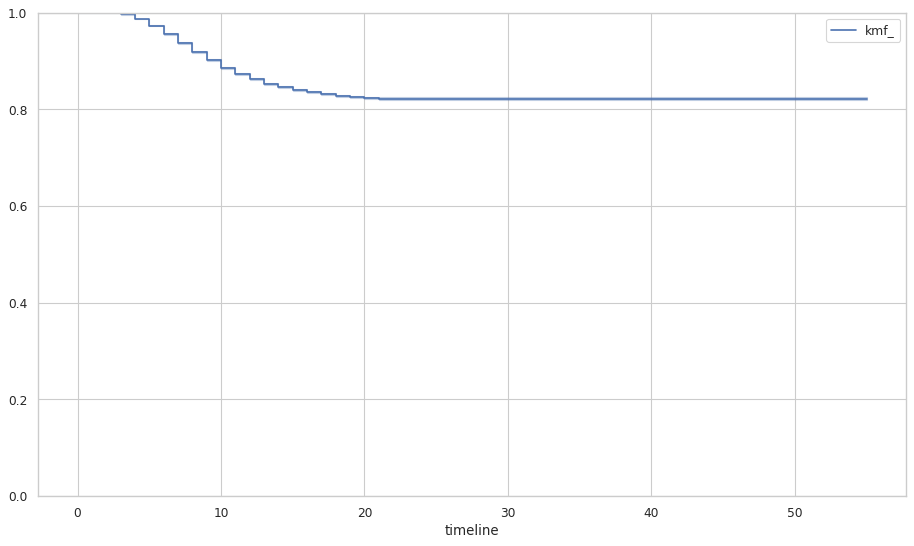

In [24]:
italy_mortality_analysis = covid19.MortalityAnalysis('Italy', first_date=pd.to_datetime('2020-02-21'))
italy_mortality_analysis.fit()
print(italy_mortality_analysis.death_rate())
italy_mortality_analysis2 = covid19.MortalityAnalysis('Italy', first_date=pd.to_datetime('2020-02-21'), init_add=2000, mult=6.0)
italy_mortality_analysis2.fit()
print(italy_mortality_analysis2.death_rate())
print(italy_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
italy_mortality_analysis.plot()

In [25]:
italy_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-03,119827,19758,14681,4585,1480,766
2020-04-04,124632,20996,15362,4805,1238,681
2020-04-05,128948,21815,15887,4316,819,525
2020-04-06,132547,22837,16523,3599,1022,636
2020-04-07,135586,24392,17127,3039,1555,604


In [26]:
italy_mortality_analysis2.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,24105.0,17127,6978.0,498.0,14,17445.0


In [27]:
italy_mortality_analysis2.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,23976.0,16523,7453.0,532.0,14,18633.0


In [37]:
# italy_mortality_analysis2.prepend_df

(16.77, 16.47, 17.07)
(2.8, 2.75, 2.86)
856452


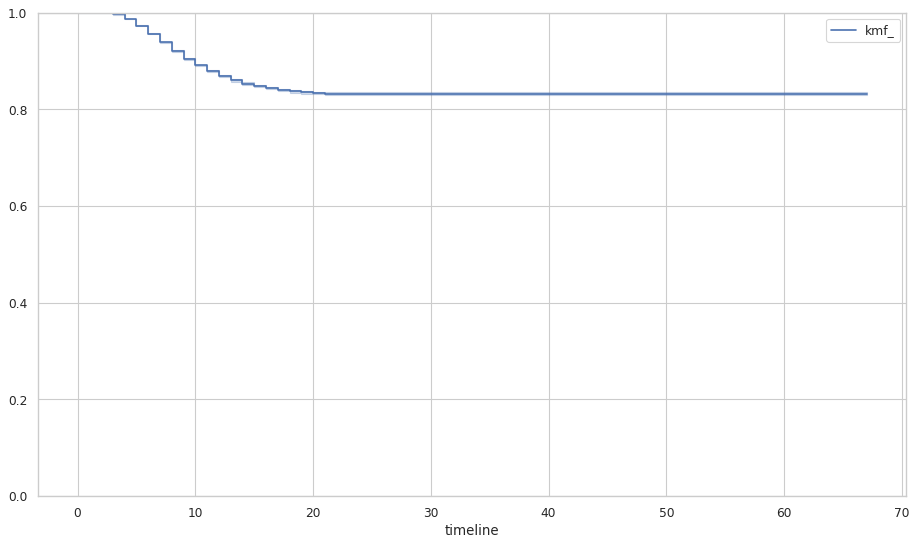

In [27]:
spain_mortality_analysis = covid19.MortalityAnalysis('Spain')
spain_mortality_analysis.fit()
spain_mortality_analysis2 = covid19.MortalityAnalysis('Spain', first_date=pd.to_datetime('2020-03-03'), init_add=800, mult=6.0)
spain_mortality_analysis2.fit()
print(spain_mortality_analysis.death_rate())
print(spain_mortality_analysis2.death_rate())
print(spain_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
spain_mortality_analysis.plot()

In [28]:
spain_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-03,119199,30513,11198,7134,3770,850
2020-04-04,126168,34219,11947,6969,3706,749
2020-04-05,131646,38080,12641,5478,3861,694
2020-04-06,136675,40437,13341,5029,2357,700
2020-04-07,141942,43208,14045,5267,2771,704


In [29]:
spain_mortality_analysis2.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,23981.0,14045,9936.0,710.0,14,24839.0


In [30]:
spain_mortality_analysis2.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,24168.0,13341,10827.0,773.0,14,27068.0


(19.93, 19.52, 20.36)
(3.34, 3.27, 3.42)
663390


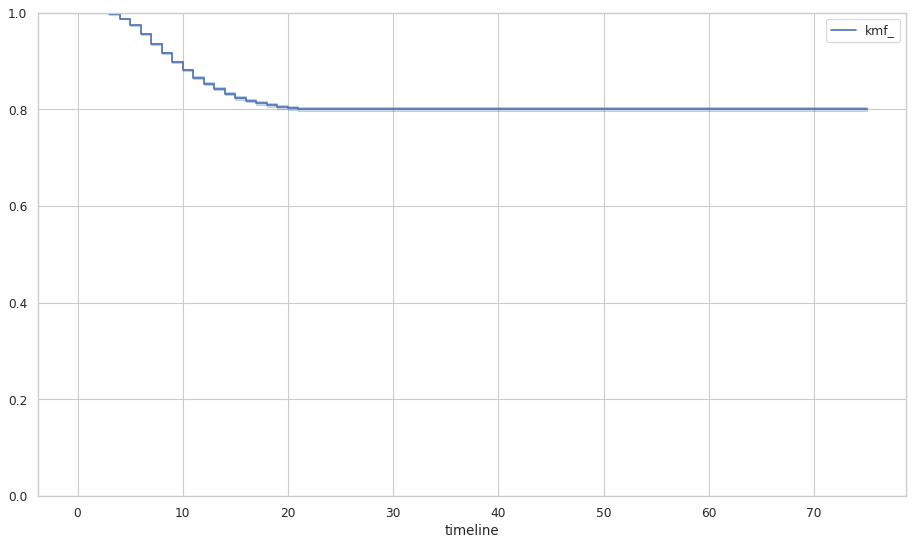

In [30]:
france_mortality_analysis = covid19.MortalityAnalysis('France')
france_mortality_analysis.fit()
france_mortality_analysis2 = covid19.MortalityAnalysis('France', first_date=pd.to_datetime('2020-02-15'), init_add=500, mult=6)
france_mortality_analysis2.fit()
print(france_mortality_analysis.death_rate())
print(france_mortality_analysis2.death_rate())
print(france_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
france_mortality_analysis.plot()

In [31]:
france_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-03,82878,14135,6520,7237,1587,1122
2020-04-04,90848,15572,7574,7970,1437,1054
2020-04-05,93773,16349,8093,2925,777,519
2020-04-06,98963,17428,8926,5190,1079,833
2020-04-07,110065,19523,10343,11102,2095,1417


In [32]:
france_mortality_analysis2.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,22157.0,10343,11814.0,844.0,14,29536.0


In [33]:
france_mortality_analysis2.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,19276.0,8926,10350.0,739.0,14,25875.0


In [34]:
import rpy2
print(rpy2.__version__)

3.2.6


In [35]:
import rpy2.robjects.packages as rpackages
baseR = rpackages.importr('base')
print(baseR.R_Version().rx('version.string'))

$version.string
[1] "R version 3.6.1 (2019-07-05)"




In [36]:
# from rpy2.rinterface import R_VERSION_BUILD
# print(R_VERSION_BUILD)

In [37]:
import IPython.display
import rpy2, rpy2.robjects, rpy2.robjects.pandas2ri, rpy2.rinterface, rpy2.robjects.packages, rpy2.interactive, rpy2.robjects.lib.ggplot2, rpy2.robjects.lib.grdevices
rpy2.robjects.pandas2ri.activate()

from rpy2.robjects.packages import importr
# import R's "base" package
base = importr('base')

# import rpy2's package module
import rpy2.robjects.packages as rpackages

# import R's utility package
utils = rpackages.importr('utils')

# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list

# R package names
packnames = ('LexisPlotR',)

# R vector of strings
from rpy2.robjects.vectors import StrVector

/home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')
/home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/rpy2/robjects/lib/ggplot2.py:72: UserWarning: This was designed againt ggplot2 version 3.2.1 but you have 3.3.0
  'have %s' % (TARGET_VERSION, ggplot2.__version__))
/home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/rpy2/robjects/vectors.py:927: UserWarning: R object inheriting from "POSIXct" but 

In [38]:
grdevices = rpy2.robjects.packages.importr('grDevices')
# Selectively install what needs to be install.
# We are fancy, just because we can.
names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
if len(names_to_install) > 0:
    utils.install_packages(StrVector(names_to_install))

lexis = importr('LexisPlotR')
lexis

rpy2.robjects.packages.Package as a <module 'LexisPlotR'>

In [39]:
lexis_grid = rpy2.robjects.r['lexis.grid']
lexis_lifeline = rpy2.robjects.r['lexis.lifeline']

In [40]:
def plot_lexis(mortality_analysis_instance):
    mylexis = lexis_grid(year_start = 2020, year_end = 2021, age_start = 0, age_end = 1) #  lwd = 0.1

    alpha = 1.0
    ix_present = ~mortality_analysis_instance.df_lifelines_individual.observed_death
    ix_lost    = mortality_analysis_instance.df_lifelines_individual.observed_death
    mylexis = lexis_lifeline(lg = mylexis , entry = mortality_analysis_instance.df_lifelines_individual['start_date'][ix_present], exit = mortality_analysis_instance.df_lifelines_individual['end_date'][ix_present], colour = "orange", alpha = alpha, lwd = 0.4)
    mylexis = lexis_lifeline(lg = mylexis , entry = mortality_analysis_instance.df_lifelines_individual['start_date'][ix_lost]   , exit = mortality_analysis_instance.df_lifelines_individual['end_date'][ix_lost]   , colour = "blue"  , alpha = alpha, lwd = 0.4, lineends = True)

    with rpy2.robjects.lib.grdevices.render_to_bytesio(grdevices.png, width=1.5*1024, height=1.5*896, res=90) as img:
        rpy2.robjects.r.print(mylexis)   
    IPython.display.display(IPython.display.Image(data=img.getvalue(), format='png', embed=True))

In [41]:
# plot_lexis(italy_mortality_analysis)

In [42]:
# plot_lexis(italy_mortality_analysis2)

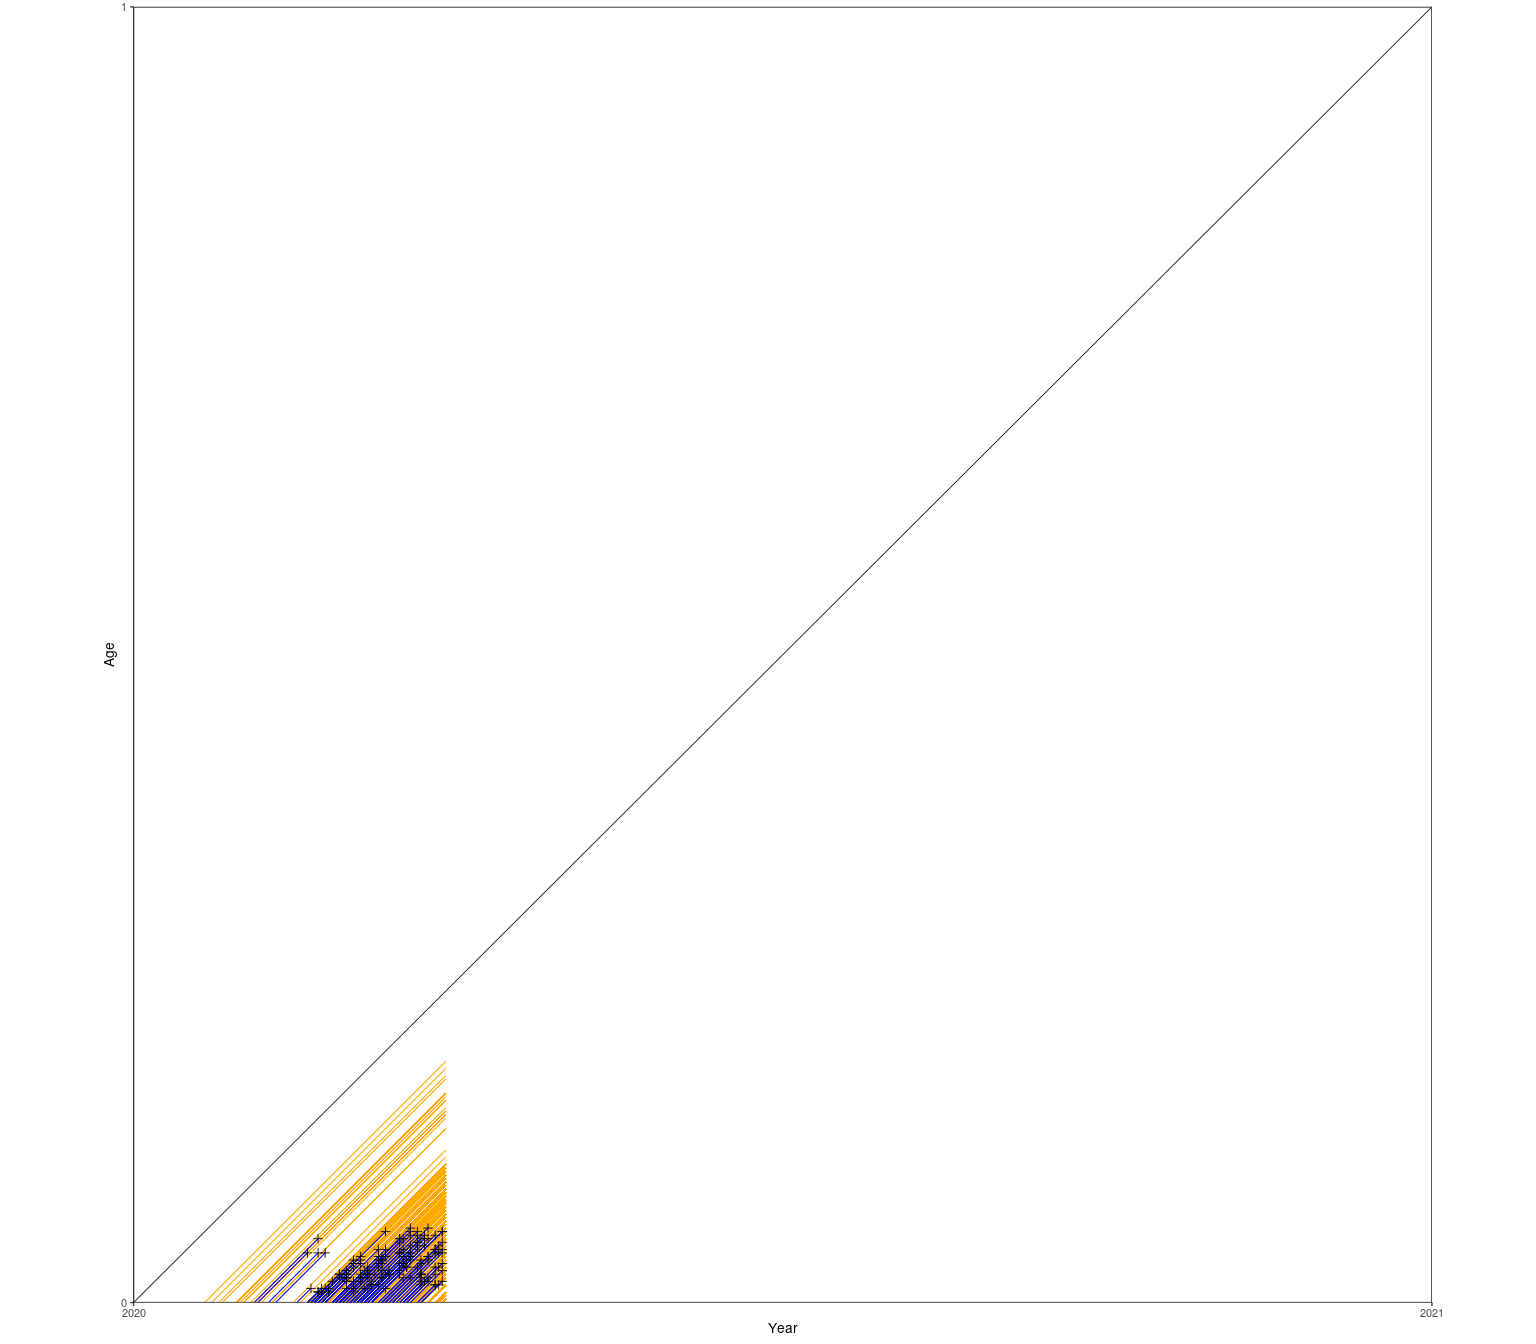

In [43]:
plot_lexis(south_korea_mortality_analysis)